# Setup

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

from deap import algorithms, base, creator, tools

from sympy import *

sys.path.append('../promoter_solving/')
from promoter_solving_core import *

In [33]:
# Load csv with mRNA_ratio, MA_act, MA_inh
data = pd.read_csv('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv', index_col=0)
data.head()

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.019182,0.028499,2.186692
control__wt_glc__2,-0.019182,-0.028499,2.369230
fur__wt_dpd__1,-0.963901,-0.473642,0.490542
fur__wt_dpd__2,-1.116929,-0.541595,0.492320
fur__wt_fe__1,0.043720,-0.054857,1.756930


# Create Grids for Each Condition

In [60]:
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = data.index)
grid.loc[:,'mRNA_ratio'] = data.loc[:,'actual_mRNA_ratio']

In [61]:
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [62]:
# Define constants
constant_vals = {
    # NOTE: MAKE SURE TO UPDATE IF ANYTHING IS CHANGED
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6, 
}

input_range = {
    'cActivator': [0,10],
    # 'cInhibitor': [0,10], # Calculate cInhibitor values based on cActivator range
}

In [67]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

# Parameter we are solving for using the other two
solve = 'cInhibitor'

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    working_grid = create_parameter_grid(num_steps = 11, **input_range)

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(working_grid):
        values['cActivator'] = pair[0]
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc[solve,'order']])
    
        # Evaluate the lambda function
        working_grid[ii] += ((lambda_df.loc[solve,'lambda'](values_tuple))[0],)
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [71]:
grid.head()

,mRNA_ratio,grid
control__wt_glc__1,2.186692,"[(0.0, -0.6215098252031866), (1.0, 9.141322501..."
control__wt_glc__2,2.369230,"[(0.0, -0.6618609214775106), (1.0, 7.953538493..."
fur__wt_dpd__1,0.490542,"[(0.0, 1.1894055061723103), (1.0, 62.447836310..."
fur__wt_dpd__2,0.492320,"[(0.0, 1.180971427188386), (1.0, 62.1995688511..."
fur__wt_fe__1,1.756930,"[(0.0, -0.49339972486388645), (1.0, 12.9124004..."


# DEAP

In [70]:
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (-1.0,))

creator.create(name = 'individual',
               base = np.ndarray,
               fitness = creator.fitness)

toolbox = base.Toolbox()

In [5]:
random.seed(42)

def create_individual(individual_class: type, data: pd.DataFrame):
    dimensions = data.shape
    locations = random.sample(range(dimensions[1]),dimensions[0])
    individual = individual_class(data.iloc[i,locations[i]] for i in data.index)

    return individual

In [6]:
toolbox.register(alias = 'individual',
                 function = create_individual,
                 individual_class = creator.individual,
                 data = toy_data) # CHANGE

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

In [7]:
test_population = toolbox.population(n=3)
test_population

[individual([[0.011, 5.   ],
             [0.05 , 5.   ],
             [3.5  , 5.   ],
             [9.1  , 0.8  ]]),
 individual([[0.03, 6.  ],
             [0.05, 5.  ],
             [0.75, 0.5 ],
             [5.04, 0.05]]),
 individual([[0.09, 9.  ],
             [1.  , 9.  ],
             [3.5 , 5.  ],
             [9.1 , 0.8 ]])]

In [8]:
# Evaluate
def objective(individual: object, MA_df: pd.DataFrame):
    dot_product = []
    for i in MA_df.index:
        dot_product.append((np.dot([MA_df.iloc[i,0],MA_df.iloc[i,1]],individual[i]))**2)
    sum_dots = np.sum(dot_product)
    
    return -sum_dots,

toolbox.register(alias = 'evaluate', function = objective, MA_df = MA_df)

In [9]:
toolbox.evaluate(test_population[0])

(-444.218125,)

In [10]:
# NOTE: Not sure what appropriate tournament size should be
toolbox.register("select", tools.selTournament, tournsize=5)

# NOTE: Using np.ndarray individuals requires a different method to compare individuals
hof = tools.HallOfFame(3, similar=np.array_equal)

In [11]:
# Mutation
def mutate(individual: object, prob: float, data: pd.DataFrame):
    dimensions = data.shape
    for i, vals in enumerate(individual):
        if random.random() < prob:
            individual[i] = list(data.iloc[i,random.sample(range(dimensions[1]),1)])[0]

    return individual,

toolbox.register('mutate', function = mutate, prob = 1, data = toy_data) # CHANGE

In [12]:
test_iteration = toolbox.mutate(test_population[0])
test_iteration

(individual([[ 0.011,  5.   ],
             [ 0.05 ,  5.   ],
             [ 6.5  , 10.   ],
             [ 8.02 ,  0.6  ]]),)

In [13]:
# Crossover
toolbox.register('mate', tools.cxESBlend, alpha=0.1)

In [14]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [15]:
MU = 10
LAMBDA = 20
pop = toolbox.population(n=30)

pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=MU, lambda_=LAMBDA, 
            cxpb=0, mutpb=0.3, ngen=1000, stats=stats, halloffame=hof, verbose=False)

In [16]:
logbook

[{'gen': 0,
  'nevals': 30,
  'avg': -421.34475749999996,
  'std': 121.82679999448156,
  'min': -656.5585249999999,
  'max': -215.398125},
 {'gen': 1,
  'nevals': 5,
  'avg': -552.780675,
  'std': 86.26021614723089,
  'min': -621.7824999999999,
  'max': -374.91885},
 {'gen': 2,
  'nevals': 8,
  'avg': -581.83906,
  'std': 61.0146124389756,
  'min': -621.7824999999999,
  'max': -488.6377},
 {'gen': 3,
  'nevals': 1,
  'avg': -621.7825,
  'std': 1.1368683772161603e-13,
  'min': -621.7824999999999,
  'max': -621.7824999999999},
 {'gen': 4,
  'nevals': 2,
  'avg': -621.7825,
  'std': 1.1368683772161603e-13,
  'min': -621.7824999999999,
  'max': -621.7824999999999},
 {'gen': 5,
  'nevals': 9,
  'avg': -645.615415,
  'std': 30.611128966031703,
  'min': -689.7824999999999,
  'max': -621.7824999999999},
 {'gen': 6,
  'nevals': 5,
  'avg': -676.24833,
  'std': 22.493809600767936,
  'min': -689.7824999999999,
  'max': -621.7824999999999},
 {'gen': 7,
  'nevals': 4,
  'avg': -689.7825,
  'std': 1

In [17]:
toolbox.evaluate(hof[0])

(-691.2824999999999,)

In [18]:
hof[0]

individual([[ 0.09,  9.  ],
            [ 1.  ,  9.  ],
            [ 6.5 , 10.  ],
            [ 9.1 ,  0.8 ]])

In [19]:
MA_df

,activator,inhibitor
0,0.0,-2.0
1,0.5,-0.7
2,0.7,-0.3
3,2.0,0.0


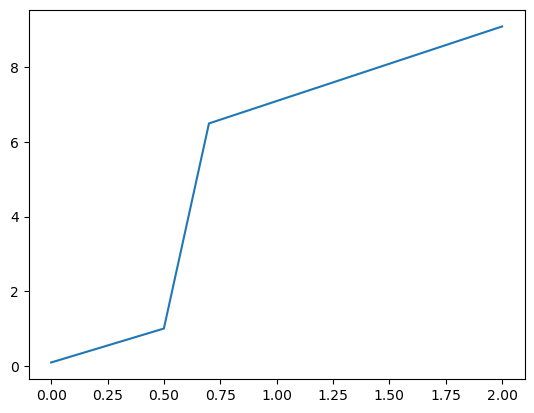

In [20]:
plt.plot(MA_df.iloc[:,0], [0.09, 1, 6.5, 9.1])

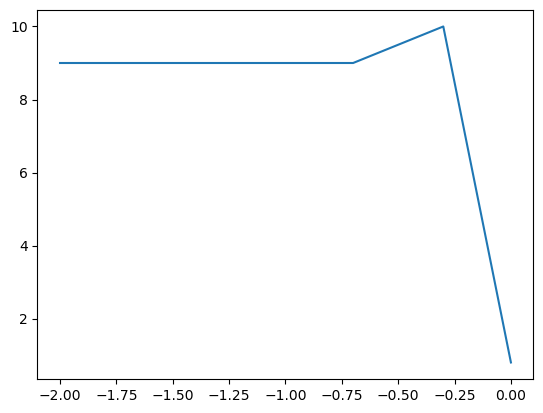

In [21]:
plt.plot(MA_df.iloc[:,1], [9, 9, 10, 0.8])